**OBJECTIVE**: Classify Amazon Fine Food Reviews using LSTMs and observe performance of different LSTM Architectures

In [ ]:
# Importing the libraries required for the dataset

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


In [ ]:
# Load the Drive helper and mount
from google.colab import files
uploaded = files.upload()

Saving Reviews.csv to Reviews.csv


In [ ]:
import io
filtered_data = pd.read_csv(io.BytesIO(uploaded['Reviews.csv']))

In [ ]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Removing the reviews which have been rated 3 star
filtered_data = filtered_data[filtered_data.Score != 3]

In [ ]:
# Checking whether the data has been filtered properly

filtered_data['Score'].unique()

# We can see that there is no 3 star review in the data

array([5, 1, 4, 2])

In [ ]:
# As we have eliminated the data with 3 start reviews, we will label the remaining data(4 and 5 scores) as positive and negative(1 and 2 scores).

# Creating a function to label the data
def partition(x):
    if x < 3:
        return '0'
    return '1'


# Applying the labels to the data

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [ ]:
# Let us look at the shape of the data

filtered_data.shape

(525814, 10)

In [ ]:
# Dropping any duplicates if they are present in the data

duplicates_dropped=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
duplicates_dropped.shape

(364173, 10)

In [ ]:
# Eliminating the rows where helpfulness numerator is greator than the helfulness denominator

final=duplicates_dropped[duplicates_dropped.HelpfulnessNumerator<=duplicates_dropped.HelpfulnessDenominator]

In [ ]:
# Taking a look at the shape of the data

final.shape

(364171, 10)

In [ ]:
# We will select only the required columns of which we will filter required reviews and assign them their labels and sort them wrt time

final_data = final[['ProductId','Time','Text','Score']]


In [ ]:
# Checking the dimension of the data
final_data.shape


(364171, 4)

In [ ]:
# Randomly selecting only 5000 reviews from the final_data

# First we will extract the values from the given dataframe

X=final_data.iloc[:,:].values

# randomly extracting 100000 reviews from the dataset

import random

n = 364171
m = 100000
p = m/n

sampled_data = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_data.append(X[i,:])



In [ ]:
# Assigning the extracted data to a dataframe

names = ['ProductId','Time','Text','Score']

sample = pd.DataFrame(sampled_data,columns= names)

In [ ]:
# Checking the dimensions of the sampled data

sample.shape

(99873, 4)

In [ ]:
# Checking the first few rows of the data

sample.head()

,ProductId,Time,Text,Score
0,B00813GRG4,1346976000,Product arrived labeled as Jumbo Salted Peanut...,0
1,B000UA0QIQ,1307923200,If you are looking for the secret ingredient i...,0
2,B006K2ZZ7K,1340150400,This saltwater taffy had great flavors and was...,1
3,B006K2ZZ7K,1336003200,This taffy is so good. It is very soft and ch...,1
4,B000E7L2R4,1322006400,Right now I'm mostly just sprouting this so my...,1


In [ ]:
# Now we will sort the data according to timestamp

sorted_data=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
# Checking if the data has been sorted or not

sorted_data.head(15)

,ProductId,Time,Text,Score
32443,0006641040,940809600,I can remember seeing the show when it aired o...,1
46648,B00004RYGX,951523200,What happens when you say his name three times...,1
46639,B00004RYGX,959990400,I'm getting crazy.I'm looking for Beatlejuice ...,1
28798,B00004RAMX,965001600,I have just recently purchased the Woodstream ...,1
46641,B00004RYGX,970531200,Beetlejuice is an awe-inspiring wonderfully am...,1
46627,B00004RYGX,978134400,"Many movies, have dealt with the figure of dea...",1
32311,B00004S1C6,982800000,I don't know why anyone would ever use those l...,1
46620,B00004RYGX,1012780800,When vacationing Adam and Barbara Maitland mee...,1
32444,0006641040,1018396800,This is a book of poetry about the months of t...,1
44543,B00005IX98,1023321600,Using the Briel Chamonix machine I purchased f...,1


In [ ]:
# We can see that the data has been sorted wrt time, now we will only consider the 'Text' and 'Score' columns henceforth

sorted_final = sorted_data[['Text','Score']]


In [ ]:
# Checking the first few rows of the data to ensure we have the right data

sorted_final.head()

,Text,Score
32443,I can remember seeing the show when it aired o...,1
46648,What happens when you say his name three times...,1
46639,I'm getting crazy.I'm looking for Beatlejuice ...,1
28798,I have just recently purchased the Woodstream ...,1
46641,Beetlejuice is an awe-inspiring wonderfully am...,1


In [ ]:
# The next task is to clean the text data so that it can be fed to the model

# Checking if there are unknown elements in the data

# find sentences containing HTML tags

import re

i=0;
for sent in sorted_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   
    
# We can see that the data contains html tags, we will need to remove those

1
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [ ]:
'''
We will perform the data cleaning steps on the text data.
For that we will import some packages for stopwords removal, word stemmatization and cleaning html and punctuation marks.
'''
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
# Assigning the cleaned text to the dataframe 'sorted_final'

sorted_final['Cleaned_Text'] = final_string

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
sorted_final['Cleaned_Text']=sorted_final['Cleaned_Text'].str.decode("utf-8")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Checking the first few rows of the data frame

sorted_final.head()

,Text,Score,Cleaned_Text
32443,I can remember seeing the show when it aired o...,1,rememb see show air televis year ago child sis...
46648,What happens when you say his name three times...,1,happen say name three time michael keaten star...
46639,I'm getting crazy.I'm looking for Beatlejuice ...,1,get crazi look beatlejuic french version video...
28798,I have just recently purchased the Woodstream ...,1,recent purchas woodstream corp gopher trap wit...
46641,Beetlejuice is an awe-inspiring wonderfully am...,1,beetlejuic wonder amus comed romp explor incre...


In [ ]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sorted_final['Cleaned_Text'], sorted_final['Score'], test_size=0.33, random_state=42)

In [ ]:
# Taking a look at the shape of our train and test datasets

print('Shape of train data: ',X_train.shape)
print('Shape of test data: ',X_test.shape)

Shape of train data:  (66914,)
Shape of test data:  (32959,)


In [ ]:
# Importing the libraries to build our lstm model

import numpy
#from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
# Creating a function to plot our train and test losses

#%matplotlib inline
%matplotlib notebook

# Importing the required libraries
import matplotlib.pyplot as plt
#import numpy as np
import time

# this function is used to update the plots for each epoch and error
def plt_dynamic(x,ty, ax, colors=['b']):
    #ax.plot(x, vy, 'b', label="Test Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [ ]:
# We will now tokenize the words and assign indexes to the words based on their frequency

# Importing the required libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [ ]:
max_features = 5000 # We will take the first 5000 features and tokenize
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Taking a look at X_train data

print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[674, 6, 1174, 683, 984, 308, 45, 449, 33, 80, 9, 439, 24, 595, 3101, 1592, 1318, 6, 683, 984, 191, 1812, 59, 32, 38, 13, 683, 984, 253, 32, 103, 7, 683, 984, 392, 449]
<class 'list'>
36


In [ ]:
# Using padding to compensate for difference in lengths of sentences

X_train = pad_sequences(X_train, maxlen=600)
X_test = pad_sequences(X_test, maxlen=600)

In [ ]:
# Checking the shape of our train and test sets

print('Shape of train data: ',X_train.shape)
print('Shape of test data: ',X_test.shape)

Shape of train data:  (66914, 600)
Shape of test data:  (32959, 600)


**MODEL 1 SINGLE LSTM LAYER**

In [ ]:
# Creating our first model

embedding_vector_length = 50

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 50)           250000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train,np.array(y_train), epochs=10, batch_size=512, verbose=1)

score = model.evaluate(X_test, np.array(y_test), verbose=0)

#print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
66914/66914 [==============================] - 166s 2ms/step - loss: 0.1700 - acc: 0.9349
Epoch 2/10
66914/66914 [==============================] - 167s 2ms/step - loss: 0.1631 - acc: 0.9377
Epoch 3/10
66914/66914 [==============================] - 167s 2ms/step - loss: 0.1581 - acc: 0.9398
Epoch 4/10
66914/66914 [==============================] - 168s 3ms/step - loss: 0.1531 - acc: 0.9418
Epoch 5/10
66914/66914 [==============================] - 168s 3ms/step - loss: 0.1490 - acc: 0.9432
Epoch 6/10
66914/66914 [==============================] - 167s 2ms/step - loss: 0.1442 - acc: 0.9456
Epoch 7/10
66914/66914 [==============================] - 168s 3ms/step - loss: 0.1389 - acc: 0.9476
Epoch 8/10
66914/66914 [==============================] - 167s 2ms/step - loss: 0.1344 - acc: 0.9496
Epoch 9/10
66914/66914 [==============================] - 168s 3ms/step - loss: 0.1292 - acc: 0.9519
Epoch 10/10
66914/66914 [==============================] - 166s 2ms/step - loss: 0.1253 - a

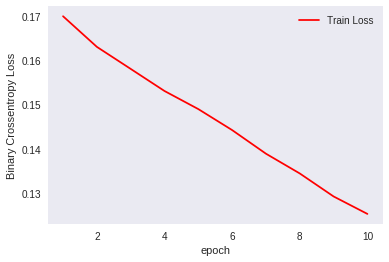

In [ ]:
epochs = 10

%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


#vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, ty, ax)

# From the figure below we can see that the model has learnt the train data as well and as the number of epochs increase, the train error reduces.

**MODEL 2 BY ADDING ANOTHER LSTM LAYER**

In [ ]:
embedding_vector_length = 50

model1 = Sequential()
model1.add(Embedding(max_features, embedding_vector_length, input_length=X_train.shape[1]))
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 50)           250000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 390,901
Trainable params: 390,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model1.fit(X_train,np.array(y_train), epochs=10, batch_size=512, verbose=1)

score = model1.evaluate(X_test, np.array(y_test), verbose=0)

#print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
66914/66914 [==============================] - 336s 5ms/step - loss: 0.3175 - acc: 0.8771
Epoch 2/10
66914/66914 [==============================] - 335s 5ms/step - loss: 0.1980 - acc: 0.9223
Epoch 3/10
66914/66914 [==============================] - 336s 5ms/step - loss: 0.1792 - acc: 0.9307
Epoch 4/10
66914/66914 [==============================] - 334s 5ms/step - loss: 0.1706 - acc: 0.9345
Epoch 5/10
66914/66914 [==============================] - 335s 5ms/step - loss: 0.1602 - acc: 0.9379
Epoch 6/10
66914/66914 [==============================] - 335s 5ms/step - loss: 0.1494 - acc: 0.9434
Epoch 7/10
66914/66914 [==============================] - 336s 5ms/step - loss: 0.1382 - acc: 0.9484
Epoch 8/10
66914/66914 [==============================] - 336s 5ms/step - loss: 0.1285 - acc: 0.9519
Epoch 9/10
66914/66914 [==============================] - 328s 5ms/step - loss: 0.1191 - acc: 0.9555
Epoch 10/10
66914/66914 [==============================] - 325s 5ms/step - loss: 0.1084 - a

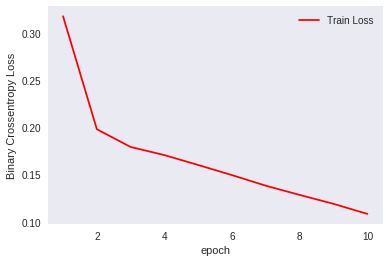

In [ ]:
epochs = 10

%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


#vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, ty, ax)

# From the figure below we can see that the model has learnt the train data as well and as the number of epochs increase, the loss reduces.

In [ ]:


# We will store the results in a single table to get 

import prettytable
from prettytable import PrettyTable

list1 = ['One Layer LSTM ','Two Layer LSTM']
list2 = ['0.235','0.026']
list3 = ['91.52%','91.11%']


print('The scores for the different LSTM architectures are:')
table = PrettyTable(['LSTM Architecture','Binary Crossentropy Loss on Test Data','Accuracy on Test Data'])
for x in range(0,2):
    table.add_row([list1[x],list2[x],list3[x]])
                                       
print(table) 

The scores for the different LSTM architectures are:
+-------------------+---------------------------------------+-----------------------+
| LSTM Architecture | Binary Crossentropy Loss on Test Data | Accuracy on Test Data |
+-------------------+---------------------------------------+-----------------------+
|  One Layer LSTM   |                 0.235                 |         91.52%        |
|   Two Layer LSTM  |                 0.026                 |         91.11%        |
+-------------------+---------------------------------------+-----------------------+


**OBSERVATION AND CONCLUSION**  

1.We can observe that the two layer LSTM architecture took almost twice the amount of time to run than the single layer architecture. 

2.The loss on the test data reduced significantly while using the two layer architecture (0.026) than while using the single layer architecture(0.235).

3.The accuracy decreased minutely by 0.41% from One Layer Architecture to Two Layer Architecture.